In [1]:
import numpy as np
import cv2

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib import rcParams
from shapely.geometry import MultiPoint, box

# from pyquaternion.quaternion import Quaternion
from pyquaternion import Quaternion
import os.path as osp
from nuscenes import NuScenes

# Utils for Lidar and Radar
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import view_points
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.data_classes import RadarPointCloud
from nuscenes.scripts.export_2d_annotations_as_json import get_2d_boxes, post_process_coords

from typing import Tuple, List, Dict, Union

%matplotlib inline

## Loading the dataset

In [2]:
#nusc = NuScenes(version='v1.0-mini',dataroot='/content/drive/My Drive/AI_S/ML/NuScenes/v1.0-mini')
nusc = NuScenes(version='v1.0-mini', dataroot='/home/sherlock/Documents/nuScenes/data', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.4 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## Obtaining Scene

In [3]:
# Select Scene 9
my_scene = nusc.scene[9]
my_scene

{'token': 'e233467e827140efa4b42d2b4c435855',
 'log_token': '8fefc430cbfa4c2191978c0df302eb98',
 'nbr_samples': 40,
 'first_sample_token': 'a480496a5988410fbe3d8ed6c84da996',
 'last_sample_token': 'abf3d91d3c28407e80e3334fe89c03cb',
 'name': 'scene-1100',
 'description': 'Night, peds in sidewalk, peds cross crosswalk, scooter, PMD, difficult lighting'}

In [4]:
# Obtain First sample token from the scene
first_sample_token = my_scene['first_sample_token']

## Obtaining sample from Scene

In [5]:
# Get sample from token
my_sample = nusc.get('sample', first_sample_token)
my_sample

{'token': 'a480496a5988410fbe3d8ed6c84da996',
 'timestamp': 1542800987947699,
 'prev': '',
 'next': 'b993550e60054741983f8052ba97b0b0',
 'scene_token': 'e233467e827140efa4b42d2b4c435855',
 'data': {'RADAR_FRONT': '511dba7f4aec41ea8baa9019ba97413c',
  'RADAR_FRONT_LEFT': 'b5a62f9cf0ac444cbd90c2f9ba7fedbf',
  'RADAR_FRONT_RIGHT': 'e95132afd0604448b6d522a09bad7e2d',
  'RADAR_BACK_LEFT': 'cb1a9aa2b8154fde9442eaa9fe11a958',
  'RADAR_BACK_RIGHT': 'f2008e1cb0194ee49a85243ed8261955',
  'LIDAR_TOP': 'b723df2123fe473d85512c9d02156c27',
  'CAM_FRONT': '51ceae8a5ecc4730950666723c135bc8',
  'CAM_FRONT_RIGHT': '4a85ae2a6329487abed596b0b7b6dfa4',
  'CAM_BACK_RIGHT': '646b51a45a2b4494a918ff89d36027e2',
  'CAM_BACK': 'd340a8d85c874b8d9e9ddf51a82a5908',
  'CAM_BACK_LEFT': 'c418396afb5a43a4af9a3b76278fd8d6',
  'CAM_FRONT_LEFT': '255a0637ea9a461989d7fb20f4ee126c'},
 'anns': ['9ca2a9ab9b5041278eea928681e09d89',
  '9dfee0c127f548acb80bf95610437acb',
  'b2222d3c49c447ba91247501e97d772b',
  '723bee443cf6433a9

## Obtaining a sample from a Camera

The cameta dictionary is: 
{'token': '4a85ae2a6329487abed596b0b7b6dfa4', 'sample_token': 'a480496a5988410fbe3d8ed6c84da996', 'ego_pose_token': '4a85ae2a6329487abed596b0b7b6dfa4', 'calibrated_sensor_token': '302e35d6ff604f17adf2ccdebce473d1', 'timestamp': 1542800987920339, 'fileformat': 'jpg', 'is_key_frame': True, 'height': 900, 'width': 1600, 'filename': 'samples/CAM_FRONT_RIGHT/n015-2018-11-21-19-38-26+0800__CAM_FRONT_RIGHT__1542800987920339.jpg', 'prev': '', 'next': 'd86cb7c0403c4f81a34648193796fa92', 'sensor_modality': 'camera', 'channel': 'CAM_FRONT_RIGHT'}


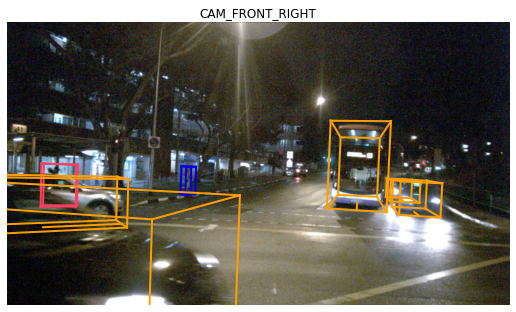

In [6]:
# Camera to use
sensor_camera = 'CAM_FRONT_RIGHT'

# Sample data from Sensor
cam_data = nusc.get('sample_data', my_sample['data'][sensor_camera])
# Render the current scene
nusc.render_sample_data(cam_data['token'])
# Print the dictionary
print('The cameta dictionary is: \n{}'.format(cam_data))

## Obtaining a instance 

{'token': 'fb2873a3231945249b1fe1acf0cedf1d',
 'sample_token': 'a480496a5988410fbe3d8ed6c84da996',
 'instance_token': '88b7a3d6e9394198a1511642a5aa5499',
 'visibility_token': '4',
 'attribute_tokens': ['cb5118da1ab342aa947717dc53544259'],
 'translation': [1315.676, 902.276, 0.406],
 'size': [1.836, 4.416, 1.43],
 'rotation': [0.8854193832467303, 0.0, 0.0, 0.4647929816283586],
 'prev': '',
 'next': '59ea3960081c49a4a579e83805f5efe2',
 'num_lidar_pts': 659,
 'num_radar_pts': 1,
 'category_name': 'vehicle.car'}

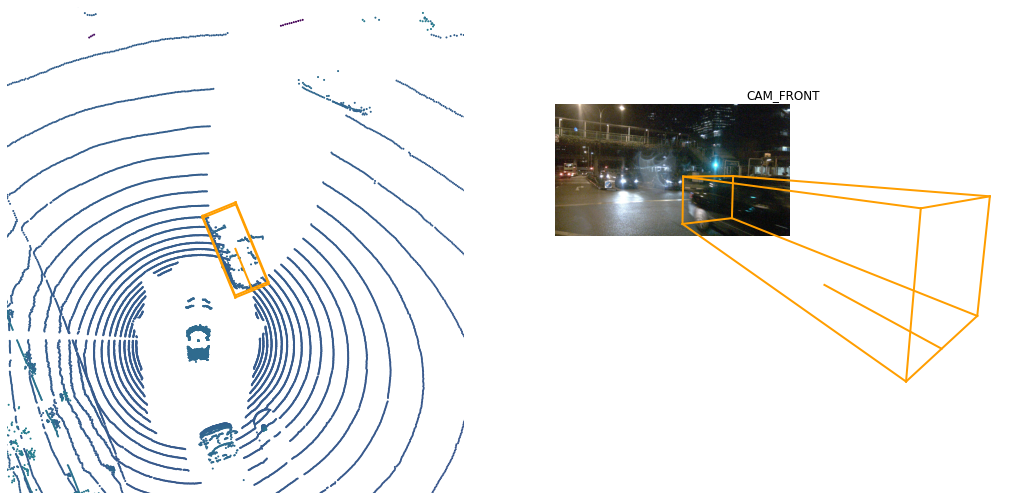

In [7]:
# Obtain the token from an instance in the sample
my_annotation_token = my_sample['anns'][23] #23
#gets sample ann from token
my_annotation_metadata =  nusc.get('sample_annotation', my_annotation_token)
nusc.render_annotation(my_annotation_token)
my_annotation_metadata

## Transformation instances from the current camera sensor

In [8]:
#get_2d_boxes(sample_data_token: str, visibilities: List[str]) -> List[OrderedDict]:

# Get the calibrated sensor and ego pose record to get the transformation matrices.
# From camera to ego
cs_rec = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
# From ego to world coordinate frame
pose_rec = nusc.get('ego_pose', cam_data['ego_pose_token'])
# Camera intrinsic parameters
camera_intrinsic = np.array(cs_rec['camera_intrinsic'])

## Printing the instance's target attributes

In [28]:
# Get the box in global coordinates from sample ann token 
box = nusc.get_box(my_annotation_metadata['token'])
print("The target's label is: \n{}".format(box))
print('The number of lidar points hitting the target are: {}'.format(my_annotation_metadata['num_lidar_pts']))
my_annotation_metadata

The target's label is: 
label: nan, score: nan, xyz: [1315.68, 902.28, 0.41], wlh: [1.84, 4.42, 1.43], rot axis: [0.00, 0.00, 1.00], ang(degrees): 55.39, ang(rad): 0.97, vel: nan, nan, nan, name: vehicle.car, token: fb2873a3231945249b1fe1acf0cedf1d
The number of lidar points hitting the target are: 659


{'token': 'fb2873a3231945249b1fe1acf0cedf1d',
 'sample_token': 'a480496a5988410fbe3d8ed6c84da996',
 'instance_token': '88b7a3d6e9394198a1511642a5aa5499',
 'visibility_token': '4',
 'attribute_tokens': ['cb5118da1ab342aa947717dc53544259'],
 'translation': [1315.676, 902.276, 0.406],
 'size': [1.836, 4.416, 1.43],
 'rotation': [0.8854193832467303, 0.0, 0.0, 0.4647929816283586],
 'prev': '',
 'next': '59ea3960081c49a4a579e83805f5efe2',
 'num_lidar_pts': 659,
 'num_radar_pts': 1,
 'category_name': 'vehicle.car'}

## Mapping the Box from World coordinate to Camera coordinate

In [29]:
# Mapping the box from world coordinate-frame to camera sensor
# Move them to the ego-pose frame.
box.translate(-np.array(pose_rec['translation']))
box.rotate(Quaternion(pose_rec['rotation']).inverse)

# Move them to the calibrated sensor frame.
box.translate(-np.array(cs_rec['translation']))
box.rotate(Quaternion(cs_rec['rotation']).inverse)

## Filter the box for data in Z < 0 (behind the camera)

In [30]:
# Filter out the corners that are not in front of the calibrated sensor.
# 8 corners of the 3d bounding box
corners_3d = box.corners()
# corners that are behind the sensor are removed
in_front = np.argwhere(corners_3d[2, :] > 0).flatten()
corners_3d = corners_3d[:, in_front]

In [31]:
# Project 3d box to 2d.
corner_coords = view_points(corners_3d, camera_intrinsic, True).T[:, :2].tolist()
print("Box number of coords: {}".format(np.array(corner_coords).shape))

Box number of coords: (8, 2)


## Plot the results

min_x: 0
min_y: 511
max_x: 741
max_y: 900


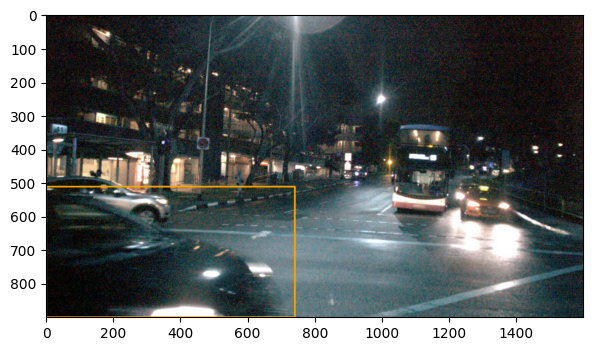

In [32]:
# Extract coorners

# Filter points that are outside the image
final_coords = post_process_coords(corner_coords)

min_x, min_y, max_x, max_y = [int(coord) for coord in final_coords]

print("min_x: {}".format(min_x))
print("min_y: {}".format(min_y))
print("max_x: {}".format(max_x))
print("max_y: {}".format(max_y))

# Load image from dataroot
img_path = osp.join(nusc.dataroot, cam_data['filename'])
img = cv2.imread(img_path, 1)

# Draw rectangle on image with coords
img_r = cv2.rectangle(img, (min_x,min_y),(max_x,max_y),(255, 165, 0) , 3)

plt.figure(figsize=(12, 4), dpi=100)
plt.imshow(img_r)
plt.show()

# Mapping Target to Camera

This short method maps a label in the world-coordinate frame to the interest-camera coordinate frame.

In [39]:
def target_to_cam(camera_token: str,
                  annotation_token: str,
                  camera_channel: str = 'CAM_FRONT'):
    """
    Given an annotation token (3d detection in world coordinate frame) and camera sample_data token,
    transform the label from world-coordinate frame to camera.
    :param camera_channel: Camera channel name, e.g. 'CAM_FRONT'.
    :param camera_token: Camera sample_data token.
    :param annotation_token: Camera sample_annotation token.
    :return box with the labels for the 3d detection task.
    """
    
    # Camera sample        
    cam_data = nusc.get('sample_data', camera_token) # Sample camera info
        
    # From camera to ego
    cs_rec = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
    # Transformation metadata from ego to world coordinate frame
    pose_rec = nusc.get('ego_pose', cam_data['ego_pose_token'])
    
    # Obtain the annotation from the token
    annotation_metadata =  nusc.get('sample_annotation', annotation_token)
    
    # Obtain box parameters
    box = nusc.get_box(annotation_metadata['token'])
                                           
    # Move them to the ego-pose frame.
    box.translate(-np.array(pose_rec['translation']))
    box.rotate(Quaternion(pose_rec['rotation']).inverse)

    # Move them to the calibrated sensor frame.
    box.translate(-np.array(cs_rec['translation']))
    box.rotate(Quaternion(cs_rec['rotation']).inverse)
    
    return box

In [41]:
new_box = target_to_cam(cam_data['token'], my_annotation_token, camera_channel = 'CAM_FRONT_RIGHT')
print(new_box)

label: nan, score: nan, xyz: [-2.57, 0.81, 3.39], wlh: [1.84, 4.42, 1.43], rot axis: [-0.99, -0.12, 0.08], ang(degrees): -92.19, ang(rad): -1.61, vel: nan, nan, nan, name: vehicle.car, token: fb2873a3231945249b1fe1acf0cedf1d


# Mapping Lidar and Radar point Cloud to interest camera

In [ ]:
## Mamame el bicho Gus